In [135]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import os
import sys
from ipywidgets import widgets
from IPython.display import display, HTML
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

# Customized modules
HOME = '/home/serinatan/project/GPU-Virtualization-Benchmarks/util'
if HOME not in sys.path:
    sys.path.append(HOME)

import data.scripts.common.format as fmt
import data.scripts.common.constants as const

SCRIPT_PATH = os.path.join(HOME, 'data/scripts') 
PKL_PATH = os.path.join(HOME, 'data/pickles') 
CSV_PATH = os.path.join(HOME, 'data/csv')

%config InlineBackend.figure_format ='retina'
plt.style.use('seaborn-talk')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def draw_table(df, cols, hide_index=True):
    if hide_index:
        return df[cols].style.set_table_styles(fmt.table_style).hide_index()
    else:
        return df[cols].style.set_table_styles(fmt.table_style)

# Inter-SM sharing pairs

In [116]:
gen_pair = os.path.join(SCRIPT_PATH, 'gen_tables/gen_table_pair.py')
baseline = 'seq'
seq_pkl = os.path.join(PKL_PATH, 'seq.pkl')
inter_pkl = os.path.join(PKL_PATH, 'inter.pkl')
csv = os.path.join(HOME, 'data/csv/pair_inter.csv')
output = os.path.join(PKL_PATH, 'pair_inter.pkl')

%run $gen_pair --csv $csv --output $output --seq_pkl $seq_pkl --how inter --isolated_pkl $inter_pkl

In [117]:
df_inter = pd.read_pickle(output)
print(df_inter.shape)
df_inter.sort_values(['1_bench', '2_bench'], inplace=True)
df_inter.reset_index(inplace=True, drop=True)

# FIXME: drop any rows with zero fairness
df_inter = df_inter[df_inter['fairness'] > 0]


(118, 229)


In [118]:
# Only show best performance for each benchmark pair
df_inter_show = df_inter.sort_values('ws', ascending=False).drop_duplicates(['1_bench','2_bench'])
df_inter_show.reset_index(inplace=True, drop=True)

df_inter_show['delta'] = df_inter_show['norm_ipc_sum'] - df_inter_show['ws']

col_inter_show = ['1_bench', '1_inter', '1_sld', 
                    '2_bench', '2_inter', '2_sld', 'ws', 'fairness', 'delta']
draw_table(df_inter_show, col_inter_show, False).format({'avg_dram_bw_x':'{:.4f}',
                                                         'avg_dram_bw_y':'{:.4f}',
                                                         'delta': '{:.2f}'    
                                                        })

,1_bench,1_inter,1_sld,2_bench,2_inter,2_sld,ws,fairness,delta
0,parb_cutcp-0,48,1.00024,rod_heartwall-0,32,1.02788,2.02812,0.973109,-0.01
1,nvd_blackscholes-0,40,0.996233,parb_cutcp-0,40,0.971767,1.968,0.975442,0.05
2,parb_cutcp-0,16,0.955481,parb_spmv-0,64,0.991697,1.94718,0.963481,-0.02
3,parb_cutcp-0,16,0.959332,rod_streamcluster-0,64,0.974202,1.93353,0.984736,0.03
4,parb_cutcp-0,40,0.947682,parb_lbm-0,40,0.981951,1.92963,0.965101,0.06
5,cut_wmma-0,48,0.927393,parb_cutcp-0,32,0.992023,1.91942,0.93485,0.04
6,nvd_blackscholes-0,48,1.01609,rod_heartwall-0,32,0.900092,1.91618,0.885842,0.10
7,cut_wmma-0,48,0.916904,rod_heartwall-0,32,0.960348,1.87725,0.954762,0.10
8,parb_cutcp-0,32,0.987072,parb_stencil-0,48,0.879843,1.86691,0.891366,0.05
9,parb_cutcp-0,24,0.966268,rod_hotspot3d-0,56,0.876882,1.84315,0.907494,0.07


=== inter-SM stats ===
** Total **
WS geomean: 1.2982
Naive prediction average delta: 0.24
------------------------------
** Greater than 1.0 WS **
Proportion: 0.85
WS geomean: 1.3732
Greater than 1.0 naive delta: 0.16
------------------------------
** Greater than 1.5 WS **
Proportion: 0.28
WS geomean:  1.7374
Greater than 1.5 naive delta:  0.11


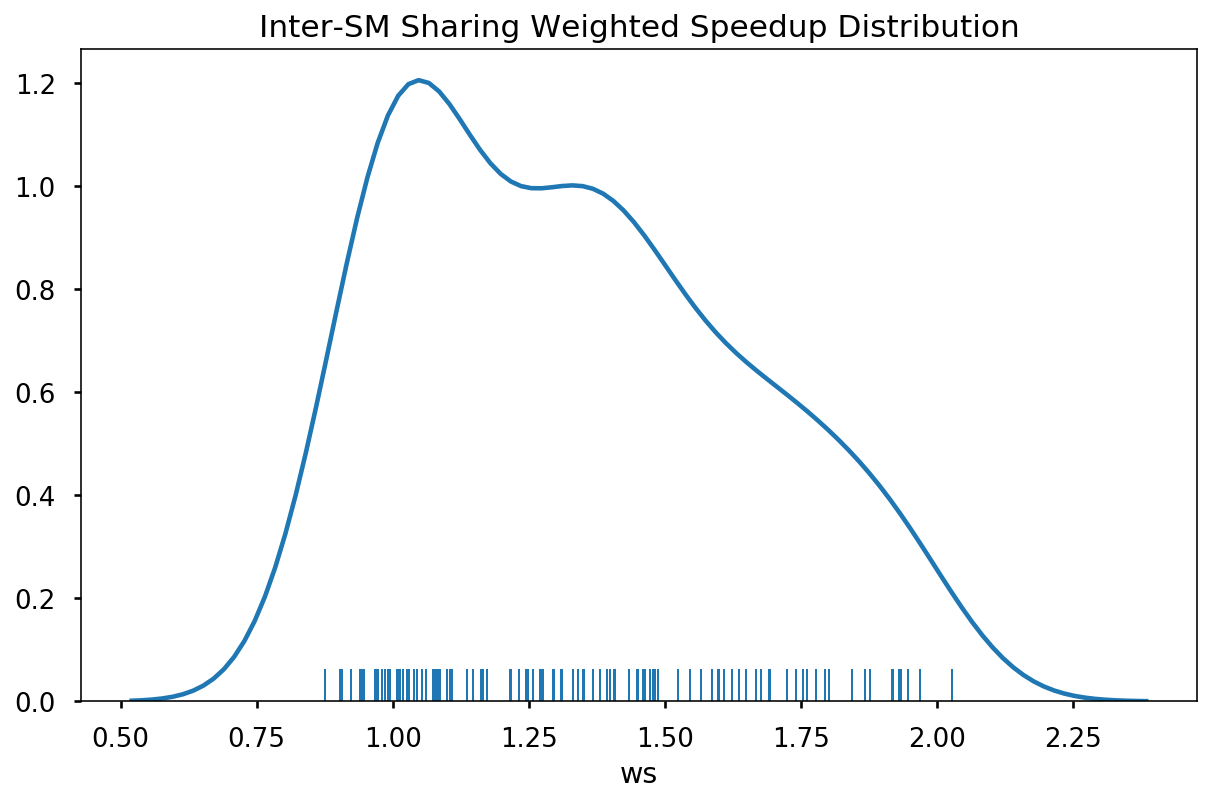

In [133]:
print('=== inter-SM stats ===')
print('** Total **')
print('WS geomean: %.4f'% scipy.stats.mstats.gmean(df_inter_show['ws']))
print('Naive prediction average delta: %.2f'% np.average(df_inter_show['delta']))

print('-'*30)

df_gt_1_inter = df_inter_show[df_inter_show['ws'] > 1.0]
print('** Greater than 1.0 WS **')
print('Proportion: %.2f' % (len(df_gt_1_inter.index)/len(df_inter_show.index)))
print('WS geomean: %.4f'% scipy.stats.mstats.gmean(df_gt_1_inter['ws']))
print('Greater than 1.0 naive delta: %.2f'% np.average(df_gt_1_inter['delta']))

print('-'*30)

df_gt_15_inter = df_inter_show[df_inter_show['ws'] > 1.5]
print('** Greater than 1.5 WS **')
print('Proportion: %.2f' % (len(df_gt_15_inter.index)/len(df_inter_show.index)))
print('WS geomean:  %.4f'% scipy.stats.mstats.gmean(df_gt_15_inter['ws']))
print('Greater than 1.5 naive delta:  %.2f'% np.average(df_gt_15_inter['delta']))

plt.figure(figsize=(10, 6))
sns.distplot(df_inter['ws'], hist=False, rug=True);
plt.title('Inter-SM Sharing Weighted Speedup Distribution')
plt.show()

# Intra-SM sharing pairs

In [120]:
df_dynamic = pd.read_pickle(os.path.join(PKL_PATH, 'pair_dynamic.pkl'))
print(df_dynamic.shape)
df_dynamic.sort_values(['1_bench', '2_bench'], inplace=True)
df_dynamic.reset_index(inplace=True, drop=True)


(1371, 255)


In [121]:
# Only show best performance for each benchmark pair
df_dynamic_show = df_dynamic.sort_values('ws', ascending=False).drop_duplicates(['1_bench','2_bench'])
df_dynamic_show.reset_index(inplace=True, drop=True)

df_dynamic_show['delta'] = df_dynamic_show['sum_ipc'] - df_dynamic_show['ws']

col_dynamic_show = ['1_bench', 'intra_x', '1_sld', 
                    '2_bench', 'intra_y', '2_sld', 'ws', 'fairness', 'delta']
draw_table(df_dynamic_show, col_dynamic_show, False).format({'avg_dram_bw_x':'{:.4f}',
                                                             'avg_dram_bw_y':'{:.4f}',
                                                             'sum_bw_x':'{:.4f}',
                                                             'delta': '{:.2f}'
                                                            })

,1_bench,intra_x,1_sld,2_bench,intra_y,2_sld,ws,fairness,delta
0,nvd_binomial-0,8,0.977654,parb_spmv-0,8,1.06215,2.0398,0.920447,0.04
1,parb_cutcp-0,2,0.993212,rod_heartwall-0,1,1.02495,2.01817,0.96903,-0.02
2,parb_cutcp-0,2,0.967691,parb_spmv-0,6,1.03856,2.00625,0.931764,0.07
3,parb_cutcp-0,2,0.969548,parb_stencil-0,4,1.03095,2.0005,0.940442,0.05
4,nvd_interval-0,6,1.05843,parb_cutcp-0,2,0.940004,1.99844,0.88811,0.06
5,nvd_blackscholes-0,4,1.01356,parb_cutcp-0,2,0.968685,1.98224,0.955728,0.05
6,nvd_interval-0,6,1.04826,rod_heartwall-0,1,0.92388,1.97214,0.881344,0.09
7,parb_spmv-0,8,1.00107,rod_lavamd-0,4,0.957624,1.9587,0.956596,0.16
8,nvd_binomial-0,13,1.04584,rod_heartwall-0,1,0.909719,1.95556,0.869846,0.04
9,nvd_fdtd3d-0,1,0.998412,parb_cutcp-0,2,0.957095,1.95551,0.958618,0.04


=== intra-SM stats ===
** Total **
WS geomean: 1.4359
Naive prediction average delta: 0.43
------------------------------
** Greater than 1.0 WS **
Proportion: 0.93
WS geomean: 1.4796
Greater than 1.0 naive delta: 0.40
------------------------------
** Greater than 1.5 WS **
Proportion: 0.51
WS geomean: 1.7431
Greater than 1.5 naive delta: 0.21


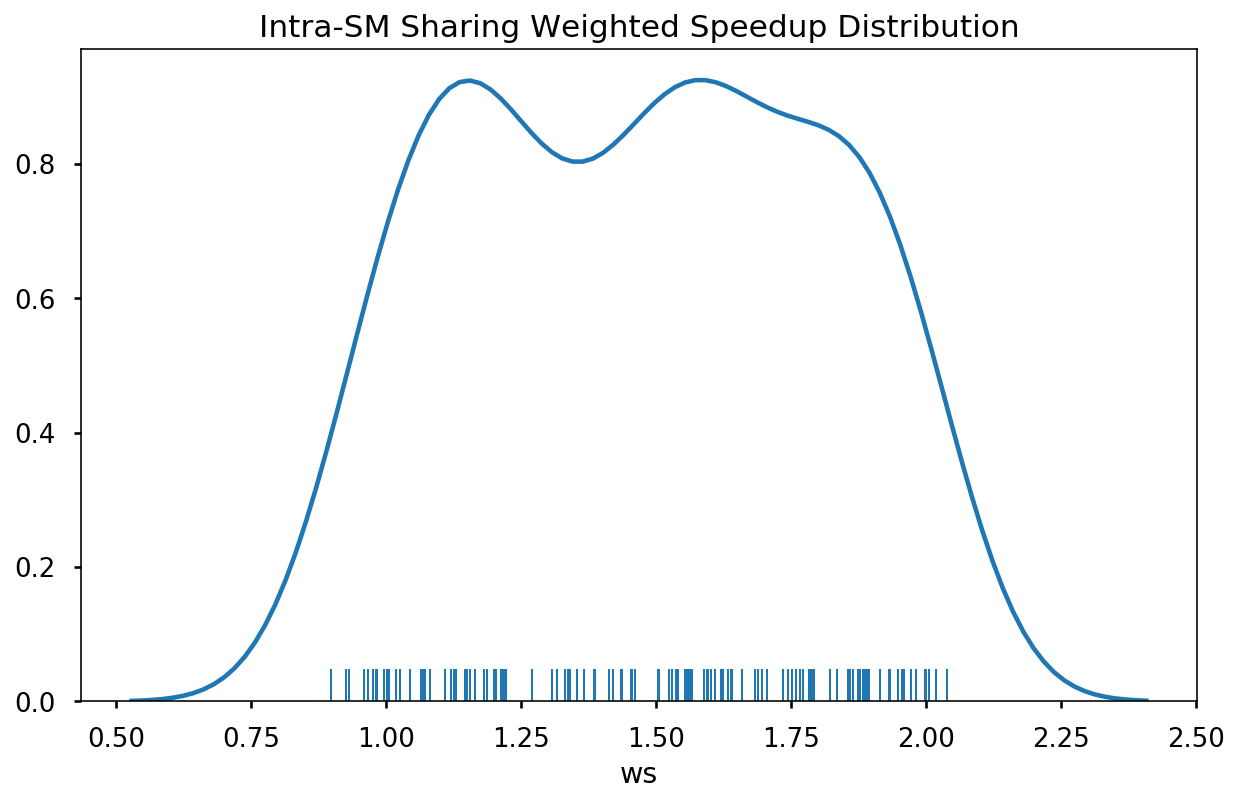

In [134]:
print('=== intra-SM stats ===')
print('** Total **')
print('WS geomean: %.4f' % scipy.stats.mstats.gmean(df_dynamic_show['ws']))
print('Naive prediction average delta: %.2f' % np.average(df_dynamic_show['delta']))

print('-'*30)

df_gt_1_intra = df_dynamic_show[df_dynamic_show['ws'] > 1.0]
print('** Greater than 1.0 WS **')
print('Proportion: %.2f' % (len(df_gt_1_intra.index)/len(df_dynamic_show.index)))
print('WS geomean: %.4f' % scipy.stats.mstats.gmean(df_gt_1_intra['ws']))
print('Greater than 1.0 naive delta: %.2f' % np.average(df_gt_1_intra['delta']))

print('-'*30)

df_gt_15_intra = df_dynamic_show[df_dynamic_show['ws'] > 1.5]
print('** Greater than 1.5 WS **')
print('Proportion: %.2f' % (len(df_gt_15_intra.index)/len(df_dynamic_show.index)))
print('WS geomean: %.4f' % scipy.stats.mstats.gmean(df_gt_15_intra['ws']))
print('Greater than 1.5 naive delta: %.2f' % np.average(df_gt_15_intra['delta']))

plt.figure(figsize=(10, 6))
sns.distplot(df_dynamic_show['ws'], hist=False, rug=True);
plt.title('Intra-SM Sharing Weighted Speedup Distribution')
plt.show()

# Compare Inter-SM and Intra-SM

In [128]:
df_both = pd.merge(df_inter_show, df_dynamic_show, on=['1_bench', '2_bench'], suffixes=('_inter', '_intra'))
df_both['intra-inter'] = df_both['ws_intra'] - df_both['ws_inter']
col_both = ['1_bench', '2_bench', 'ws_inter', 'ws_intra', 'intra-inter']

def highlight_error(s):
    is_neg = s < -0.1
    return ['background-color: yellow' if v else '' for v in is_neg]


draw_table(df_both, col_both, False).apply(highlight_error, subset=['intra-inter'])

,1_bench,2_bench,ws_inter,ws_intra,intra-inter
0,parb_cutcp-0,rod_heartwall-0,2.02812,2.01817,-0.00995362
1,nvd_blackscholes-0,parb_cutcp-0,1.968,1.98224,0.0142419
2,parb_cutcp-0,parb_spmv-0,1.94718,2.00625,0.0590708
3,parb_cutcp-0,parb_lbm-0,1.92963,1.88322,-0.0464156
4,cut_wmma-0,parb_cutcp-0,1.91942,1.93291,0.0134962
5,nvd_blackscholes-0,rod_heartwall-0,1.91618,1.66034,-0.255835
6,cut_wmma-0,rod_heartwall-0,1.87725,1.83491,-0.0423439
7,parb_cutcp-0,parb_stencil-0,1.86691,2.0005,0.133583
8,parb_cutcp-0,rod_hotspot3d-0,1.84315,1.88818,0.0450288
9,nvd_fdtd3d-0,parb_cutcp-0,1.80042,1.95551,0.155082


In [124]:
def highlight_usage(s):
    colors = []
    for v in s:
        if v < 0.1:
            colors.append('background-color: green')
        elif v < 0.2:
            colors.append('background-color: yellow')
        else:
            colors.append('background-color: red')
    return colors

df_seq = pd.read_pickle(os.path.join(PKL_PATH, 'seq.pkl'))
df_comp = df_seq[df_seq.apply(lambda x: (const.app_dict[x['pair_str']][2] == 1),axis=1)]
df_comp.set_index('pair_str', inplace=True)

col_seq = ['sp_busy', 'dp_busy', 'int_busy', 'tensor_busy', 'sfu_busy']
draw_table(df_comp, col_seq, False).apply(highlight_usage, 
                                         subset=['sp_busy', 'dp_busy', 'int_busy', 'tensor_busy', 'sfu_busy'])


,sp_busy,dp_busy,int_busy,tensor_busy,sfu_busy
pair_str,,,,,
cut_sgemm-1,0.351627,0,0.147064,0,0
cut_wmma-0,0.000967,0,0.051946,0.240054,0
nvd_binomial-0,0.378521,0,0.039163,0,0.001047
nvd_sobol-0,0.017147,0,0.48315,0,0
parb_cutcp-0,0.045542,0,0.013996,0,0.022947
rod_heartwall-0,0,0,0.027635,0,0.016938
rod_hotspot-0,0.022402,0.184569,0.32232,0,0.062064
rod_lavamd-0,0.012069,0.597422,0.117729,0,0
rod_pathfinder-0,0,0,0.359393,0,0


In [125]:
def comp_comp(row):
    return row['1_bench'] in df_comp.index and row['2_bench'] in df_comp.index

df_cc = df_both[df_both.apply(comp_comp, axis=1)].copy()

def sum_usage(row, metric):
    return (df_comp.loc[row['1_bench'], metric] > 0.1) and (df_comp.loc[row['2_bench'], metric] > 0.1)

df_cc['sp_sum'] = df_cc.apply(lambda row: sum_usage(row, 'sp_busy'), axis=1)
df_cc['dp_sum'] = df_cc.apply(lambda row: sum_usage(row, 'dp_busy'), axis=1)
df_cc['int_sum'] = df_cc.apply(lambda row: sum_usage(row, 'int_busy'), axis=1)
df_cc['tensor_sum'] = df_cc.apply(lambda row: sum_usage(row, 'tensor_busy'), axis=1)
df_cc['sfu_sum'] = df_cc.apply(lambda row: sum_usage(row, 'sfu_busy'), axis=1)


col_cc = col_both + ['sp_sum', 'dp_sum', 'int_sum', 'tensor_sum', 'sfu_sum']

def highlight_conflict(s):
    is_conflict = (s == True)
    return ['background-color: yellow' if v else '' for v in is_conflict]

draw_table(df_cc, col_cc, False).apply(highlight_conflict, 
                                       subset=['sp_sum', 'dp_sum', 'int_sum', 'tensor_sum', 'sfu_sum'])

,1_bench,2_bench,ws_inter,ws_intra,intra-inter,sp_sum,dp_sum,int_sum,tensor_sum,sfu_sum
0,parb_cutcp-0,rod_heartwall-0,2.02812,2.01817,-0.00995362,False,False,False,False,False
4,cut_wmma-0,parb_cutcp-0,1.91942,1.93291,0.0134962,False,False,False,False,False
6,cut_wmma-0,rod_heartwall-0,1.87725,1.83491,-0.0423439,False,False,False,False,False
10,cut_sgemm-1,parb_cutcp-0,1.79338,1.5605,-0.232879,False,False,False,False,False
12,nvd_sobol-0,parb_cutcp-0,1.76035,1.7348,-0.0255429,False,False,False,False,False
16,parb_cutcp-0,rod_hotspot-0,1.69198,1.59578,-0.0961999,False,False,False,False,False
17,nvd_sobol-0,rod_heartwall-0,1.67611,1.70654,0.0304335,False,False,False,False,False
18,cut_sgemm-1,rod_heartwall-0,1.6664,1.53998,-0.12642,False,False,False,False,False
20,nvd_binomial-0,parb_cutcp-0,1.63629,1.58919,-0.0470938,False,False,False,False,False
21,nvd_binomial-0,rod_heartwall-0,1.62373,1.95556,0.331823,False,False,False,False,False


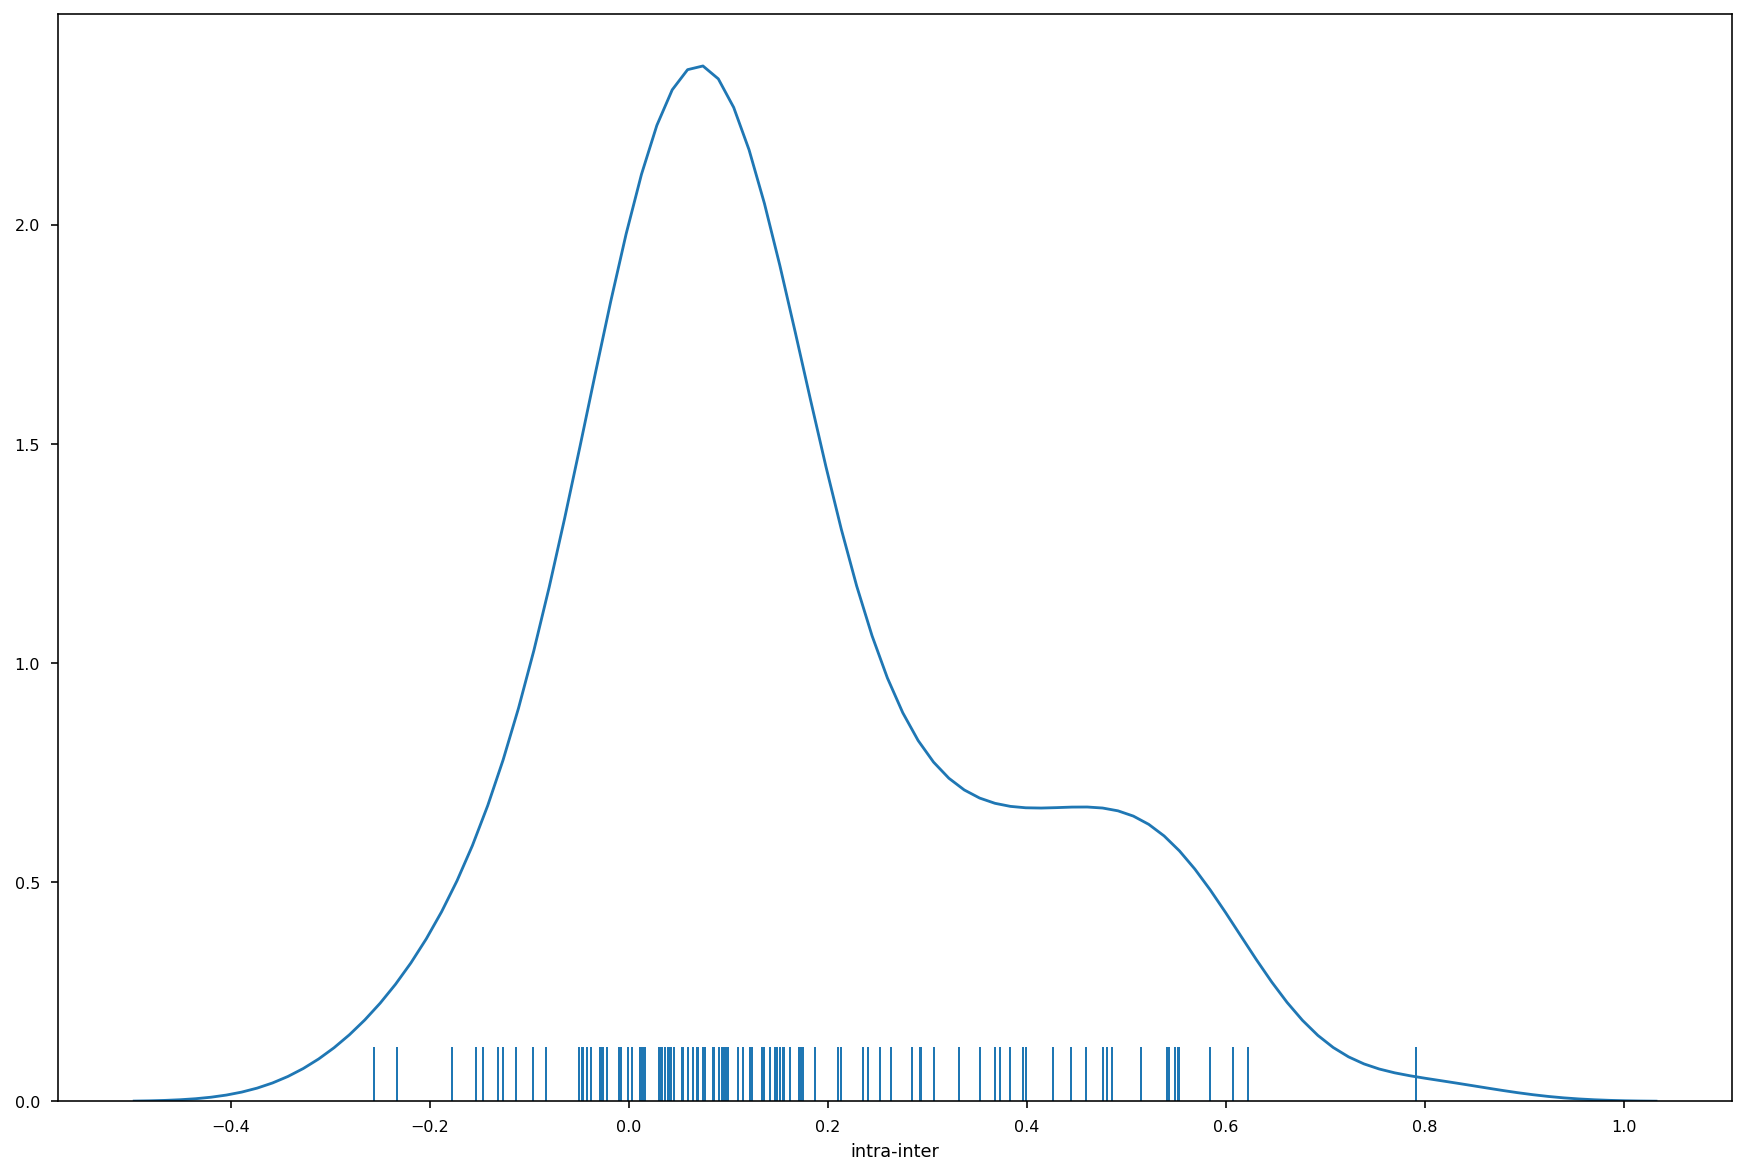

In [127]:
plt.figure(figsize=(15, 10))
sns.distplot(df_both['intra-inter'], hist=False, rug=True);
plt.show()